In [10]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
import pandas as pd, os, glob
sn.set_context('notebook')

# ECOREG basic data exploration

This notebook documents preliminary exploration of the **German** ECOREG data supplied by Daniel Herring. The raw data can be found here:

K:\Avdeling\311 Biologisk mangfold - ferskvann ny\SSC\ECOREG

## 1. Data tidying and restructuring

### 1.1. File naming conventions

Firstly, the site numbers do not seem to match between the water quality/ecology sampling locations and the flows data. Linkages must therefore be inferred from the site names, but this requires some minor changes to the file naming conventions used by the raw data. Start by copying the raw data locally and making the following changes to the flows file names:

  1. Changed all site names to lower case
  2. Changed wiedenau_2 to wiedenau2.
  3. Changed hagen_eckesey to hagen-eckesey and hagen_haspe to hagen-haspe.
  4. Changed Nespen.Qpeg.15.zrx to nespen_Qpeg_15.zrx

Next, adjust the site names in the *Overview* sheet of *sites_and_ecol.xlsx* to match the naming conventions above. Also remove the superscript '2's in the column names of the *overview (detail)* sheet, as these are awkward to manipulate in code.

### 1.2. Flows data

The raw data consists of 15-minute resolution discharge data from 31 sites in Germany. The datasets are in different file formats (.zrx and .csv) and use different date formats, as well as different delimiters for both the column and decimal separators. The code below parses the data and plots monthly average flows for each site.

In [11]:
# Define function to perform parsing and resampling

def read_resample_flows(file_name, 
                        site_name,
                        skiprows=11,
                        sep=';',
                        decimal=',',
                        index_col=False,
                        dt_format='%d.%m.%Y %H:%M:%S',
                        freq='M'):
    """ Reads flows data and resamples to the specified frequency.
    
    Args:
        file_name  File to parse
        site_name  Name of site
        skiprows   Number of rows to skip at start
        sep        Column separator
        decimal    Decimal separator
        dt_format  String specifying date format
        freq       Resampling frequency. 'D'=daily; 'M'=monthly; 'A'=Annual
    
    Returns:
        Data frame.
    """
    df = pd.read_csv(file_name, 
                     skiprows=skiprows,
                     header=None,
                     names=['Date_Time', 'Q_m3/s'],
                     index_col=False,
                     sep=sep,
                     decimal=decimal) 
    
    # Parse dates
    df.index = pd.to_datetime(df['Date_Time'], format=dt_format)
    del df['Date_Time']
    
    # Resample
    df = df.resample(freq, how='mean')
    df.reset_index(inplace=True)
    
    # Add site name as extra column
    df['Site'] = site_name
    df = df[['Site', 'Date_Time', 'Q_m3/s']]
    
    return df

In [12]:
# Process flows data

###############################################################################
# User input
in_fold = r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG\Raw_Data\Germany'
out_csv = r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG\monthly_flows.csv'
# Frequency for resampling
freq = 'M'
###############################################################################
  
# Get list of flow files to process
search_path = os.path.join(in_fold, 'Flows', '*')
file_list = glob.glob(search_path)

# Read files
df_list = []
for file_name in file_list:
    # Get site name
    site_name = os.path.split(file_name)[1].split('_')[0]
    
    # Process differently according to file extension and file formatting
    if site_name == 'hagen-eckesey':
        # This site has a different date format to the other CSV files
        df = read_resample_flows(file_name,
                                 site_name,
                                 skiprows=11,
                                 sep=';',
                                 decimal='.',
                                 dt_format='%d.%m.%Y %H:%M',
                                 freq=freq)        
        df_list.append(df)
        
    elif file_name[-3:] == 'csv':
        # The rest of the CSV files are consistent
        df = read_resample_flows(file_name,
                                 site_name,
                                 skiprows=11,
                                 sep=';',
                                 decimal=',',
                                 dt_format='%d.%m.%Y %H:%M:%S',
                                 freq=freq)        
        df_list.append(df)
        
    elif file_name[-3:] == 'zrx':
        # The ZRX files are also consistent
        df = read_resample_flows(file_name,
                                 site_name,
                                 skiprows=5,
                                 sep=' ',
                                 decimal='.',
                                 dt_format='%Y%m%d%H%M%S',
                                 freq=freq)        
        df_list.append(df)
                
    else:
        raise ValueError('Unexpected file types found in flows data folder.')

# Concatenate results
flows_df = pd.concat(df_list, axis=0)

# Pivot and write output
flows_df = flows_df.pivot(index='Date_Time', columns='Site', values='Q_m3/s')
flows_df.to_csv(out_csv)

# Print first 5 rows of restructured flows table
print flows_df.head()

Site        altenburg  attendorn   bamenohl  beddelhausen  boerlinghausen  \
Date_Time                                                                   
2002-11-30  26.230849  18.305377  19.737756     18.490204        2.889569   
2002-12-31  11.125165   7.045729  13.901247     13.825073        2.817475   
2003-01-31  28.634972  24.993858  27.295978     22.865725        3.238393   
2003-02-28  14.495826   7.792362   9.200878      5.525933        0.876088   
2003-03-31   6.954155   5.549946  12.735974     11.503120        1.736182   

Site        bredelar      broel    bueren  geisbach    gemuend    ...     \
Date_Time                                                         ...      
2002-11-30  2.778607   8.367281  2.673279  1.327665   9.301687    ...      
2002-12-31  1.176407   8.643544  1.766125  1.006928   5.342507    ...      
2003-01-31  3.549792  11.888413  5.042093  1.479826  10.533365    ...      
2003-02-28  1.346269   5.664822  2.031669  0.802001   4.867794    ...      
2003

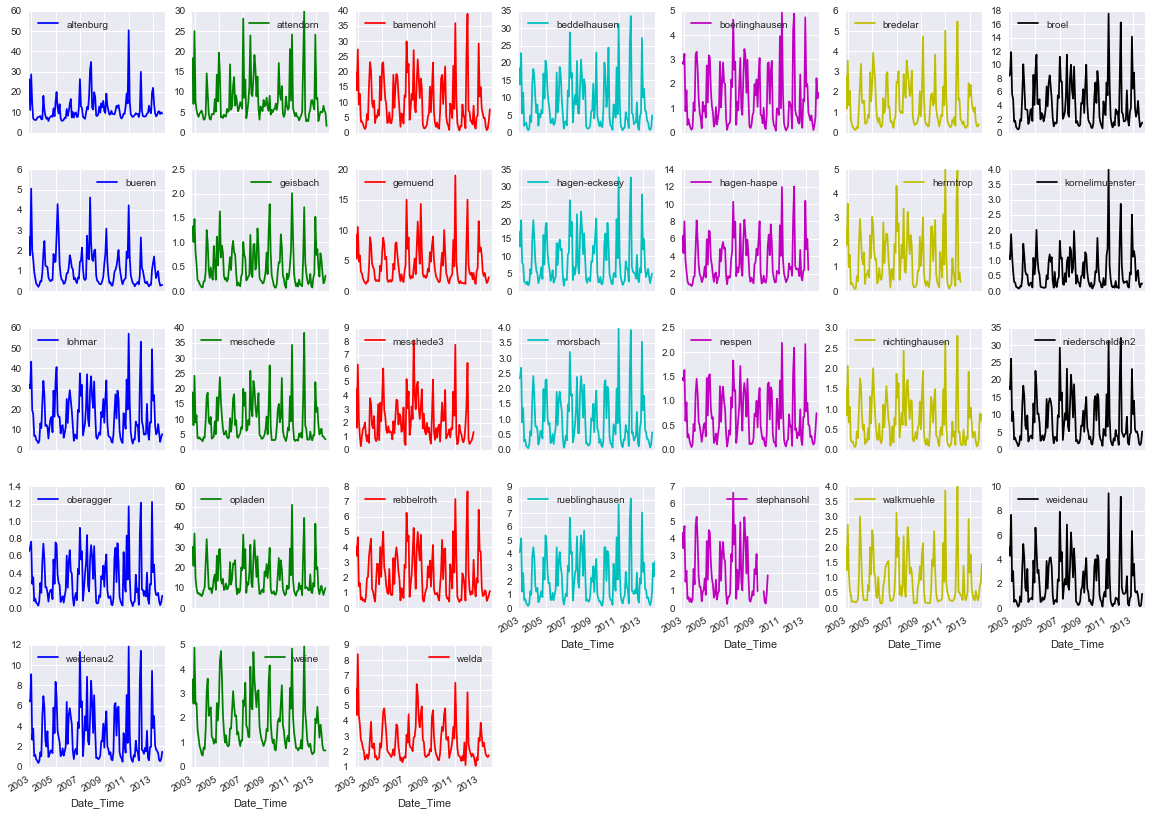

In [13]:
# Plot
flows_df.plot(subplots=True, layout=(5, 7), figsize=(20, 15), sharex=True)
plt.subplots_adjust(hspace=0.3)
plt.show()

The above plots show that, after resampling using monthly averages, we have data for most of the sites from 2003 to 2013 inclusive. Some sites also have slightly more recent data. **Stephansohl** is the only location with significant data gaps at monthly resolution.

It is also often interesting to plot the flow regime from each site, normalised by catchment area. To do this, we first need to extract the site properties from *sites_and_ecol.xlsx*.

**NB:** The *overview (detail)* sheet of *sites_and_ecol.xlsx* includes two different columns for catchment area. I assume one of these is the "official" gauged area and the other comes from someone else's catchment delineation procedure (?). In the code below, I'm assuming the values in the $km^2\_gauge$ column are correct.

In [14]:
# Get catchment areas for each site

# Input file
in_xlsx = r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG\Raw_Data\Germany\sites_and_ecol.xlsx'

# Read adjusted site names and catchment areas
names_df = pd.read_excel(in_xlsx, sheetname='overview')
areas_df = pd.read_excel(in_xlsx, sheetname=' overview (detail)')

# Inner join on site ID
sites_df = pd.merge(names_df, areas_df, how='inner', on='ID_RS')

# Extract columns of interest
sites_df = sites_df[['Site', 'km2_gauge']].drop_duplicates()
sites_df.index = sites_df['Site']
del sites_df['Site']

print sites_df

                 km2_gauge
Site                      
altenburg           958.76
attendorn           332.23
bamenohl             28.71
beddelhausen        356.00
boerlinghausen       47.98
bredelar            251.60
broel               216.00
bueren              170.05
geisbach             48.90
gemuend             344.55
hagen-eckesey       425.00
hagen-haspe         156.00
herrntrop            60.70
kornelimuenster      65.02
lohmar             1335.11
meschede            426.06
meschede3            96.28
morsbach             43.12
nespen               29.40
nichtinghausen       37.17
niederschelden2     431.00
oberagger            12.50
opladen             606.00
rebbelroth          110.40
rueblinghausen       86.00
stephansohl          95.60
walkmuehle           48.22
weidenau            287.00
weidenau2           153.00
weine               143.32
welda               433.73


We can now use this information to area-scale the flows data.

**NB:** Hovering the mouse over the plot below should show options for panning and zooming in the bottom-left corner.

In [15]:
# Plot area-scaled flow data for each site

# Copy the flows data
scaled_df = flows_df.copy()

# Scale each site by its catchment area
for site in scaled_df.columns:
    site_area = sites_df.ix[site, 'km2_gauge']
    scaled_df[site] = scaled_df[site] / site_area

# Plot
scaled_df.plot(legend=False)
mpld3.display()

The plot above is interesting: 30 out of the 31 sites plot approximately together, indicating similar runoff regimes. One of the sites (the red line above) is clearly very different. We can identify this site by calculating the mean of each data series and sorting from largest to smallest:

In [16]:
print scaled_df.mean().sort_values(ascending=False).head(1)

Site
bamenohl    0.338062
dtype: float64


So, the unusual site is **Bamenohl**. Looking at the matrix plot above, it is clear that something strange is going on at this location: the flows at Bamenohl are approximately as large as at Attendorn, but Attendorn has a catchment area of $332 \; km^2$, compared to just $29 \; km^2$ for Bamenohl.

The plot below is the same as the one above, but with the Bamenohl data series removed. This makes it easier to explore the other datasets. (As above, use the pan and zoom tools to make the data clearer).

In [17]:
# Remove Bamenohl
del scaled_df['bamenohl']

# Plot
scaled_df.plot(legend=False)
mpld3.display()

On this plot, there is some evidence of flow regulation, temporal lags etc. at some of the sites, but the overall water balances are quite similar between locations. Some key questions for the flows data:

  1. What do we know about the flow regime at each of these sites? The ECOREG proposal identifies four different classes of flow regulation (*Fig. 1* of the proposal). Are we hoping to infer these classes directly from the hydrographs (above), or do we have additional data to characterise the hydromorphology? <br><br>
  
  2. Do we know what's going on at Bamenohl?
  
### 1.3. Chemistry data

*sites_and_ecol.xlsx* contains water chemistry and ecology data for each of the sites. This section focuses on the data in the *chemistry* sheet.

**NB:** The *chemistry* sheet includes duplicates for some location-time-determinand combinations. It looks as though some of the data has been enetered twice, but with slightly different values. For the preliminary analysis below, I'm simply ignoring these duplictes, but **this needs checking**.

**NB2:** The original file contains lots of non-ASCII characters. For simplicity, it's probbaly worth removing these before any more detailed analysis, but for now I've just encoded the output using UTF-8.

**NB3:** What does the *Kennung* column in the *chemistry* sheet refer to?

In [18]:
# Output file to create
chem_csv = r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG\chemistry.csv'

# Read chemistry data
chem_df = pd.read_excel(in_xlsx, sheetname='chemistry')

# Join in site names
chem_df = pd.merge(chem_df, names_df, how='left', on='ID_RS')

# Concatenate determinands and units
chem_df['Det'] = chem_df['Parameter_cg'].map(unicode) + ' ' + chem_df['Einheit_cg']

# Extract columns of interest
chem_df = chem_df[['Site', 'Datum', 'Det', 'Wert_cg']]

# Drop duplicates. NB: This is a fudge. CHECK DATA ISSUES with Jannicke/Susi
chem_df = chem_df.drop_duplicates(subset=['Site', 'Datum', 'Det'])

# Rename columns
chem_df.columns = ['Site', 'Date', 'Det', 'Value']

# Build multi-index
chem_df.index = [chem_df['Site'], chem_df['Date'], chem_df['Det']]
del chem_df['Site'], chem_df['Date'], chem_df['Det']

# Unstack determinand
chem_df = chem_df.unstack(level='Det')

# Write output
chem_df.to_csv(chem_csv, encoding='utf-8')

print chem_df.head()

                                      Value                                    \
Det                                AFS mg/l AFS ug/l Ca mg/l Cl mg/l DOC mg/l   
Site           Date                                                             
altenburg      2009-08-31 15:00:00        3      NaN     NaN    27.0      NaN   
attendorn      2013-07-08 00:00:00        0        0       0     0.0        0   
bamenohl       2014-07-03 00:00:00        1      NaN       0     0.0      NaN   
beddelhausen   2010-08-15 15:00:00      NaN      NaN      20    20.4      NaN   
boerlinghausen 2013-07-17 00:00:00        0        0       0     0.0        0   

                                                              \
Det                                Fe mg/l GH mg/l GH mmol/l   
Site           Date                                            
altenburg      2009-08-31 15:00:00    0.11     NaN       NaN   
attendorn      2013-07-08 00:00:00     NaN     NaN         0   
bamenohl       2014-07-03 00:00

Looking at the table above, there are between 1 and 3 sets of chemistry samples for each site (and the same looks to be true for the ecology data). An approximate sampling time is given for some of the chemistry measurements, but not for others. A key question is therefore **how to link the chemistry and ecology data to the high resolution hydrology data?** For example, we could use daily, monthly or annual average hydrology (or some other statistic), depending on how representative we think the water chemistry and ecology data are of the wider flow regime.

I don't know much about ecology, but water chemistry is usually strongly correlated with flow, so I'd be wary of trying to match long-term hydrological averages to just a few chemistry samples.

### 1.4. Ecology data

I haven't looked at this yet. Perhaps next week we can discuss what the ecological indices mean for the different taxa and whether we should be considering each measurement separately or aggregating them into some kind of overall ecological score. Keeping the data separate preserves detail, but will likely lead to an **overparameterised** statistical model. Some level of aggregation will therefore almost certainly be required, but how much is something for further discussion. If necessary, we can use e.g. **feature selection** or a **clustering algorithm** to determine a suitable level of aggregation from the data itself, but a bit of ecological guidance/intuition will likely lead to a better model.